# Mushroom Classification

## Modelling Objective
Build a **Simple** and **Interpretable** Model to Perform **Binary Classification** on Edibility of Mushroom from *Agarcius and Lepiota Family*. 

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm

# Reading Dataset

The [mushroom dataset](https://archive.ics.uci.edu/ml/datasets/mushroom) includes descriptions of hypothetical samples corresponding to 23
species of gilled mushrooms in the Agaricus and Lepiota Family (pp. 500-525). 

Each species is identified as definitely *edible, definitely poisonous, or of unknown
edibility and not recommended*. This latter class was combined with the poisonous
one. 

Hence, the task given is a binary classification problem whereby, 
given the features of mushrooms, we are to classify the mushrooms 
into **p=Poisonous** or **e=edible**.

## Data Dictionary
| Columns | Descriptions |
| :--- | :--- |
| class                   | poisonous=p, edible=e| 
| cap-shape               | bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s|
| cap-surface             | fibrous=f,grooves=g,scaly=y,smooth=s |
| cap-color               | brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y|
| bruises                 | bruises=t,no=f |
| odor                    | almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s |
| gill-attachment         | attached=a,descending=d,free=f,notched=n|
| gill-spacing            | close=c,crowded=w,distant=d|
| gill-size               | broad=b,narrow=n |
| gill-color              | black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y|
| stalk-shape             | enlarging=e,tapering=t
| stalk-root              | bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,**missing=?** |
| stalk-surface-above-ring| fibrous=f,scaly=y,silky=k,smooth=s|
| stalk-surface-below-ring| fibrous=f,scaly=y,silky=k,smooth=s|
| stalk-color-above-ring  | brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y|
| stalk-color-below-ring  | brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y|
| veil-type               | partial=p,universal=u|
| veil-color              | brown=n,orange=o,white=w,yellow=y|
| ring-number             | none=n,one=o,two=t|
| ring-type               | cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z|
| spore-print-color       | black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y|
| population              | abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y|
| habitat                 | grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d|

In [ ]:
mushroom_df = pd.read_csv("../input/mushroom-classification/mushrooms.csv", 
    na_values="?", # masking "?" with Null Values
    )
mushroom_df.rename(columns = {"class":"is-edible"}, inplace = True)
mushroom_df.head()

# Exploratory Data Analysis
Understands the dataset and flag out flaws in the dataset.

## Descriptive Summaries
By running `.info()` on our dataframe, the following are the initial observation
of the dataset.

**Observations**

1. The shape of dataset is `(8124, 23)` whereby there is 8124 observations and 23 columns. 
(22 Features + 1 Target Variable: `"is-edible"`)
2. Datatype of all columns are `object`. However, from the documentation there are numerical feature which is encoded as string. **(e.g. ring-number)**
3. Missing values is observed in `"stalk-root"` columns which is around 30.5% (2480 Missing Values) of the entire dataset.

In [ ]:
mushroom_df.info()

### Unique Values Exploration
Since all our columns are encoded in string, one way to explore the values is 
number of unique values in each columns.

**Observations**

1. Constant Value Column(1 Unique Value): 

    `"veil-type"`
    
    As all datapoints have constant value = p in `"veil-type"`, it does not provide 
    any information to the target variable.
    
    > One approach is to **Drop the `"veil-type"` column entirely**.

2. Binary Columns(2 Unique Values): 

    `["is-edible"(label), "bruises", "gill-attachment", "gill-spacing", "gill-size", "stalk-shape"]`

3. Nominal Categorical Columns(>2 Unique Values):
    
    `["cap-shape", "cap-surface", "cap-color", "odor", "gill-color",
       "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring",
       "stalk-color-above-ring", "stalk-color-below-ring", "veil-color", "ring-type", 
       "spore-print-color", "population", "habitat"]`

    There are 15 Nominal Categorical which describe the characteristics of mushrooms 
    including the texture, colors, population and habitat.

    > As there are abundance of Nominal Categorical features, creating One-Hot variables 
    for all categorical features might create excessive dimensional spaces which can be 
    computational expenssive and prone to overfitting ([aka "The Curse of Dimensionality"](https://towardsdatascience.com/the-curse-of-dimensionality-50dc6e49aa1e))

    > There might be a need to explore further on feature selection and/or [dimensionality reduction](https://towardsdatascience.com/5-must-know-dimensionality-reduction-techniques-via-prince-e6ffb27e55d1) to mitigate the curse of dimensionality.
4. Discrete Numerical Columns(Countable Values):

    `"ring-number"`

    Although it is technically a numerical column, since the number of unique values is low(`nuique() == 3`), we can treat it as a categorical column during the encoding. 

In [ ]:
mushroom_df.nunique().sort_values()

### Countplot
Countplot is a convenient tool to quickly explore the count of category variables for each unique values.
Since the dataset entire dataset is made up of categorical variables, we can just generate countplot for all columns.

**Observations**

1. Balanced Label

     The class frequency of the target variable `is-edible` is relatively balanced with 4208 instances classified as edible and 3916 instances classified as poisonous.
     
2. High Cardinality for Categorical Features

     For features >2 Unique values, most of them suffer from high cardinality with minority classes. This makes the column of resulting matrix sparse if we were to perform One-Hot Encoding without any feature selection/dimension reduction.
     

In [ ]:
plt.figure(figsize=(15,10))
for i, col in enumerate(mushroom_df.columns):
    sns.set_palette(sns.color_palette("Paired"))
    ax = plt.subplot(6,4,i+1)
    sns.countplot(
        x=col, data = mushroom_df, ax = ax, 
        order = mushroom_df[col].value_counts(ascending=True).index
    )
    sns.set_style('whitegrid')
    plt.xticks(rotation=90)
    plt.ylabel("Median Price")
    plt.tight_layout()
plt.show()

**Summary:**

1. Constant Value Column exist for `veil-type` which shall be dropped as it does not bring any information of the target variable.
2. Data Cleaning/ Imputation is needed to treat missing values for `stalk-root`.
3. Encode the features into dummy variables for binary column(Unique Values = 2) and One-Hot encoding for nominal categorical columns(Unique Values >=2).
4. Feature Selection might be required to reduce the dimension of the dataset.

# Data Preprocessing
Preprocess dataset into a format that is digestible by model.

## Drop Constant Value Column

`veil-type` column is dropped as it have constant value of "p" which does not bring any information about the target variable.

In [ ]:
mushroom_df.drop(columns="veil-type", inplace = True)

## Data Cleaning and Imputation

Since there are around 30.2% of missing values observed for `stalk-root` feature, we can tryout the following approaches:

1. Drop the Entire `stalk-root` Column
2. Impute with Central Tendency(most-frequent = "b")
3. Impute with Advanced Algorithm in SKLearn (e.g. IterativeImputer, KNNImputer)

We will go with the first approach since it is the simplest solution that does not change the underlying distribution of dataset and evaluate the decision based on the model's performance later.

In [ ]:
mushroom_df.dropna(axis=1, inplace=True)

print("stalk-root" in mushroom_df.columns)

In [ ]:
from sklearn.feature_selection import chi2, RFECV
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, auc, roc_curve, plot_roc_curve

## Train-Test-Split
Splitting Data into Training and Testing Set before in-depth EDA and Preprocessing to avoid data leakage and ensures all decisions make are based on the training set and the testing set is left untouched.

In [ ]:
train_df, test_df = train_test_split(mushroom_df, test_size = 0.3, random_state = 12)
print(train_df.shape)
print(test_df.shape)

## Feature Selection
Although we have a total of 107 features after feature encoding, some of the feature might not be useful for modelling as it have too little occurrence, or they are just noises that does not bring any information about the target variable.

For that, feature selection is needed to investigate more on the strong and weak features and how we could perform some feature engineering before we start our modelling.

*All investigation and inference is made with the training set to minimize any data leakage which leads to biased result during model evaluation.

### Cramer's V Correlation Matrix
Cramer's V is a statistical test to calculate correlation in tables which have more than 2x2 rows and columns. It is used as post-test to determine strengths of association after chi-square has determined significance. 

$$
V = \sqrt{\frac{\chi^2/n}{k-1}}\\
\chi^2 : \text{chi-square}\\
k : \text{number of rows or columns in the contingency table}\\
n : \text{Number of observations}
\\
(Weak Association)0<V<1(Strong Association)
$$

Reference : [Cramer's V correlation matrix](https://www.kaggle.com/chrisbss1/cramer-s-v-correlation-matrix)

In [ ]:
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    chi2 = ss.chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    n = np.sum(crosstab) # Number of observations
    phi2 = chi2/n
    r, k = crosstab.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
rows= []
for var in mushroom_df.columns:
    cramers =cramers_V(train_df['is-edible'], train_df[var]) # Cramer's V test
    rows.append(round(cramers,2))
cramers_results = np.array(rows)
cramers_V_matrix = pd.DataFrame(cramers_results,columns = ['is-edible'] ,index = mushroom_df.columns)

In [ ]:
fig, ax = plt.subplots(figsize = (9,7))
sns.barplot(y="index", x="is-edible", data = cramers_V_matrix[['is-edible']].sort_values('is-edible').reset_index(), color = "red")
plt.title("Cramer's V Correlation to is-edible")
plt.show()
display(cramers_V_matrix[['is-edible']].sort_values('is-edible'))

From the Cremer's V statistical test, the following are the observations:

1. Odor seems to be a strong measure as the association between odor with the target variable, is-edible is very high.
2. There seems to be little association between `['stalk-shape', 'gill-attachment', 'veil-color', 'cap-surface', 'ring-number', 'cap-color', 'cap-shape']` with target variable, `"is-edible"`.
       
    This might be due to the present of some minority classes(values with little observation) or there are simply no association.

To test out the hypothesis above, we print out the contingency table for features with low Cremer's V score and perform some basic visualisation

In [ ]:
cols = ['stalk-shape', 'gill-attachment', 'veil-color', 'cap-surface', 'ring-number', 'cap-color', 'cap-shape']
for col in cols:
    display(pd.crosstab(train_df['is-edible'], train_df[col]))

By analysing the printed cross-tab the following are the observations:

1. For the features that are flagged as weak association to the target variable, some of the values seems to be a strong split and can make up a strong feature once One-Hot Encoded (e.g. gill-attachment, veil-color, ring-number, cap-shape)
2. However, there are also features where all the values are ambiguous in classifying the target variable.(e.g. stalk-shape, cap-surface) Although there might be some hidden relationship when we take account of combination for more than one features, we first attempt to **drop `["stalk-shape", "cap-surface"]` features** from our dataset and revisit the decision after modelling.

In [ ]:
train_df.drop(columns = ["stalk-shape", "cap-surface"], inplace = True)
test_df.drop(columns = ["stalk-shape", "cap-surface"], inplace = True)

## Feature Encoding (Dummies Encoding + One-Hot Encoding)
For starter, we will perform one-hot encoding for Nominal Categorical Columns(>2 Unique Values) to encode our features and target variable into values of 0 and 1.
Dummies Encoding is then used to encode Binary Columns(Unique Values = 2) with `drop=first` flag to avoid high correlation between encoded features

In [ ]:
binary_col = train_df.columns[train_df.nunique() == 2]
categorical_col = [col for col in train_df.columns if col not in binary_col]

dummy_encode_train = pd.get_dummies(train_df[binary_col], drop_first= True, prefix_sep="-") #dummy encode for binary features
onehot_encode_train = pd.get_dummies(train_df[categorical_col], drop_first= False, prefix_sep="-") #onehot encode for categorical features

dummy_encode_test = pd.get_dummies(test_df[binary_col], drop_first= True, prefix_sep="-") #dummy encode for binary features
onehot_encode_test = pd.get_dummies(test_df[categorical_col], drop_first= False, prefix_sep="-") #onehot encode for categorical features

train_onehot = pd.concat([dummy_encode_train, onehot_encode_train], axis = 1)
test_onehot = pd.concat([dummy_encode_test, onehot_encode_test], axis = 1)

display(train_onehot)
display(test_onehot)

### Splitting Features and Target Variable
After one-hot encoding, we split our training and testing set into X_train_raw, X_test_raw, y_train, y_test.

In [ ]:
X_train_raw, y_train = train_onehot.drop(columns = 'is-edible-p'), train_onehot['is-edible-p']
X_test_raw, y_test = test_onehot.drop(columns = 'is-edible-p'), test_onehot['is-edible-p']
display(X_train_raw)
display(X_test_raw)

## Recursive Feature Elimination
As we have 101 features after feature encoding, to get a simpler model, we make use of Recursive Feature Elimination with Support Vector Machine running linear kernel to perform feature selection for us by ranking the features by the score generated by LinearSVM which can find the best linear split with maximum margin, which might be helpful for us in the case of Binary Classification.

After running the feature selection process, rfe reduced the number of features recommended into just 10 features, which we will be using the selected features for modelling later on.

In [ ]:
svm = SVC(kernel='linear') #LinearSVC
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=svm, step=1, cv=5,
              scoring='accuracy',
              min_features_to_select=min_features_to_select)
rfecv.fit(X_train_raw, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [ ]:
X_train = X_train_raw.loc[:,rfecv.ranking_==1]
X_test = X_test_raw.loc[:,rfecv.ranking_==1]
print(X_train.shape)
print(X_test.shape)

# Modeling
After we have performed feature selection to limit down the number of features from 107 features to just 10 features, we are ready to make use of some sklearn model to see whether can we find some simple yet interpretable model that can help us classify whether is a mushroom poisonous.

We will first begin by exploring several simple statistical model with default parameters and make decision based on the evaluation outcome and also the interpretability

## Baseline Classifier
We use Dummy Classifier by predicting the most dominant classes : Poisonous = False and evaluate the score of the baseline predictor as reference point for model selection.

In [ ]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
print("Baseline Accuracy Score :{:.4f}".format(dummy.score(X_test, y_test)))

## Model Selection

In [ ]:
# Defining Utility Function 
def evaluate_model(models, X_train, X_test, y_train, y_test):
    hist = {}
    n_models = len(models)
    fig, axes = plt.subplots(1 + n_models // 4 ,4, figsize = (4*4, 2 + 4*(n_models//4)))
    
    for idx, model in tqdm(enumerate(models)):
        try:
            clf = model(random_state=12) # Setting random_state for certain model
        except:
            clf = model()
        clf.fit(X_train, y_train)
        yhat_train = clf.predict(X_train)
        acc_train = accuracy_score(y_train, yhat_train)
        f1_train = f1_score(y_train, yhat_train)
        
        # 5-Fold CV
        cv_hist = cross_validate(clf, X_train, y_train, scoring=['accuracy', 'f1', 'roc_auc'])

        # Record down the performance
        hist[model.__name__] = dict(
            train_acc = acc_train,
            cv_acc = cv_hist['test_accuracy'].mean(),
            train_f1_score = f1_train,
            cv_f1_score = cv_hist['test_f1'].mean(),
            cv_auc = cv_hist['test_roc_auc'].mean()
        )

        # Plotting AUC ROC Curve with Test Set *Without taking any reference for Model Selection
        plot_roc_curve(clf, X = X_test, y = y_test, ax=axes[idx//4,idx%4])
       
    plt.tight_layout()
    display(pd.DataFrame(hist).T)
    plt.show()

In [ ]:
models = [DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier, LogisticRegression, LinearSVC, KNeighborsClassifier]
evaluate_model(models, X_train, X_test, y_train, y_test)

From the accuracy report, we noticed that all the models performs quite well out-of-the-box(without hyperparameter tuning) with accuracy and auc of 1.0 for most model except Logistic Regression.

As the goal of modelling is to find the simplest model, with high interpretability, that can describe the relationship between features and target label, we continue by looking into `DecisionTreeClassifier` and perform some hyperparameter tuning to see can we get a simpler model that is still able to generalize to the sample data well.

## Model Evaluation : Logistic Regression & Decision Tree Classifier

In [ ]:
logex = LogisticRegression()
logex.fit(X_train, y_train)
yhat = logex.predict(X_test)
hist = cross_validate(logex,X_train,y_train,cv=5)
acc = accuracy_score(y_test, yhat)
print("Logistic Regression")
print("Cross Validation Score:", pd.DataFrame(hist)[["test_score"]].describe().T[["mean","std"]], sep="\n")
print("Test Set Accuracy Score: {:.4f}".format(acc))

In [ ]:
tree = DecisionTreeClassifier(random_state=12)
tree.fit(X_train, y_train)
yhat = tree.predict(X_test)
hist = cross_validate(tree,X_train,y_train,cv=5)
acc = accuracy_score(y_test, yhat)
print("Cross Validation Score:", pd.DataFrame(hist)[["test_score"]].describe().T[["mean","std"]], sep="\n")
print("Test Set Accuracy Score: {:.4f}".format(acc))

From the evaluation metrics, we observed accuracy of 1.0 during K-Fold Cross Validation and also for Hold-Out Test Set, which has not been seen by the algorithm. Hence, we continue by carrying out hyperparameter tuning to further simplify the model for better interpretability.

## Hyperparameter Tuning

In [ ]:
model = LogisticRegression()
space = dict(
    penalty = ['l2', 'l1'],
    C = np.logspace(-4,4,5),
    n_jobs = [-1]
)
clf = GridSearchCV(model, space, n_jobs=-1, cv = 5)
clf.fit(X_train, y_train)
print("Best Parameters for Logistic Regression Classifier:\n{}".format(clf.best_params_))
print("Best Score : \n{}".format(clf.best_score_))

In [ ]:
model = DecisionTreeClassifier(random_state=12)
space = dict(
    criterion = ["gini","entropy"],
    max_depth = np.arange(1,11),
    max_features = [None, "auto", "sqrt", "log2"]
)
clf = GridSearchCV(model, space, n_jobs=-1, cv = 5)
clf.fit(X_train, y_train)
print("Best Parameters for Decision Tree Classifier:\n{}".format(clf.best_params_))

Since our modelling objective is Simple and Interpretable, I have decided to go for Decision Tree Classifier due to its ability to generate an easily interpretable result in form of decision map.

# Model Intepretation
By using the best parameters generated from Grid Search Cross-validation, we train our final model and gain some insights by visualising the decision rule of the decision tree.

In [ ]:
final_model = DecisionTreeClassifier(max_depth= 5, max_features= None,random_state=12)
final_model.fit(X_train, y_train)
print("Test Accuracy Score : {:.4f}".format(final_model.score(X_test,y_test)))

### Feature Importance
From the feature importance we can tell that out of the 10 selected features, only 8 of them are used in the decision rule and `odor-n` which represents `No-odor`, is the best-feature with highest feature importance.

Meanwhile, "Black Stalk Surface Above Ring, Woods Habitat" is not utilise based on the decision rule.

Hence, we can conclude that by using only 8 true or false values, we can effectively classify whether is a mushroom poisonous or edible.

In [ ]:
pd.DataFrame(list(zip(X_train.columns, final_model.feature_importances_)), columns = ['features', 'importance']).sort_values('importance', ascending = False)

## Visualising Decision Tree

In [ ]:
fig, axes = plt.subplots(figsize = (12,9), dpi=500)
plot_tree(final_model, feature_names = X_train.columns, fontsize=7)
plt.show()

# Conclusion
From dataset with 22 categorical columns and more than 100 dummies features, we managed to spot and rectify the errors(Single-Valued Columns, Null Values) from the dataset and perform feature selection to limit down the number of features into just 10 before building the final model which only utilise only 8 features to achieve perfect classification based on the evaluation score from cross-validation and hold-out test set.

## Saving Model
After completing model training and tuning, we can save our model into external file and reload it later during deployment.

In [ ]:
# import pickle
# pickle.dump(final_model, open( "model/mushroom_classification_tree.p", "wb" )) #Dumping model into pickle file

In [ ]:
# loaded_model = pickle.load( open( "model/mushroom_classification_tree.p", "rb" ) ) #Loading model
# loaded_model.predict(X_test) #Perform prediction with loaded model

## Personal Learning Reflection
Through the mushroom classification problem, I've gained more hands-on exposure in terms of **Feature Selection** and **Feature Elimination** which is something new to me as in the past, I am more obsessed with chasing the scores at cost of model complexity. Since we can get perfect score with any modern classification models effortlessly with the mushroom dataset, **Model Interpretation** becomes the highlight since a black-box model might not be as useful than a **simple decision map** for an adventurer collecting mushroom in the woods!

Written By : Wong Zhao Wu

Last Modified : 22 May 2021 

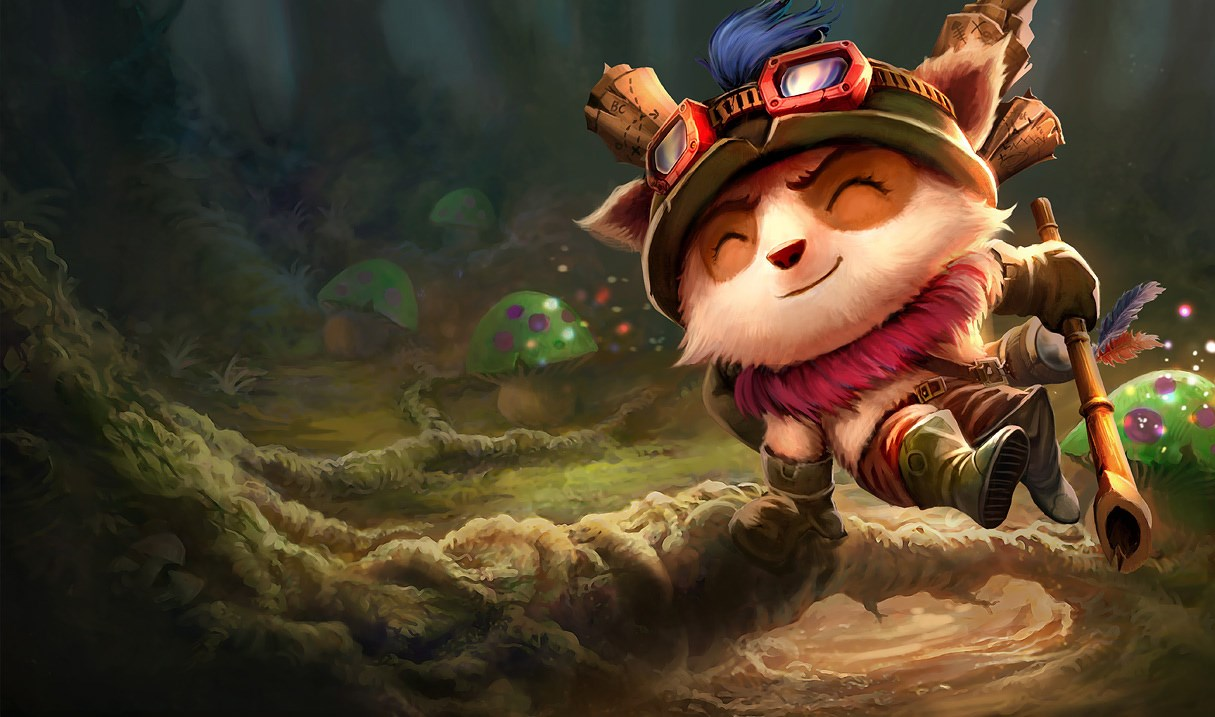

> Captain Teemo on Duty!

Image retrieved from [LeagueWiki](https://leagueoflegends.fandom.com/wiki/Teemo/LoL/Cosmetics).